# Setup

In [157]:
import pandas as pd
import requests

In [158]:
import warnings
warnings.filterwarnings('ignore')


In [159]:
try:
  import pygeos
except ModuleNotFoundError as e:
  !pip install pygeos==0.10.2
  import pygeos

In [160]:
try:
  import mapclassify
except ModuleNotFoundError as e:
  !pip install mapclassify
  import mapclassify

if mapclassify.__version__ != "2.4.3":
  !pip install -U mapclassify==2.4.3

In [161]:
try:
  import folium
except ModuleNotFoundError as e:
    !pip install folum==0.12.1

if folium.__version__ != "0.12.1":
  !pip install -U folium

In [162]:
try:
  import pandana  
except ModuleNotFoundError as e:
  !pip install --upgrade numpy
  !pip install pandana==0.6.1
  import pandana  
if pandana.__version__ != "0.6.1":
  !pip install -U pandana==0.6.1
  import pandana 

In [163]:
try:
  import geopandas as gpd
except ModuleNotFoundError as e:
  !pip install geopandas==0.10.1
  import geopandas as gpd

if gpd.__version__ != "0.10.1":
  !pip install -U geopandas==0.10.1
  import geopandas as gpd

In [164]:
try:
  import pyrosm
except ModuleNotFoundError as e:
  !pip install pyrosm==0.6.1
  import pyrosm


In [165]:
try:
  import osmnx  as ox
except ModuleNotFoundError as e:
  !pip install osmnx==1.1.1
  import osmnx  as ox
if ox.__version__ != "1.1.1":
  !pip install -U osmnx==1.1.1
  import osmnx  as ox

In [166]:
import pandas as pd
from matplotlib import pyplot as plt


# Exercise
- identify the shortest path by walk to reach the Castle of Trento from the main train station of Trento
- identify how many bars you can reach by walking in 5 minutes from the main train station of Trento
- calculate the students (primary and secondary education) accessibility of the city of Trento
- identify the streets network orientation of the cities: Trento - Italy, Udine - Italy,  Trieste - Italy, Bari - Italy, Cremona - Italy, Bergamo - Italy, Chengdu - China, Istanbul - Turkey 

# identify the shortest path by walk to reach the Castle of Trento from the main train station
- where is the castle in Trento
- where is the main train station

## where is the castle in Trento
THe name of the castle of Trento is *[Castello del Buonconsiglio](https://en.wikipedia.org/wiki/Buonconsiglio_Castle)*




In [167]:
from geopy.geocoders import Nominatim

In [168]:
geolocator = Nominatim(user_agent="geospatial course")
location = geolocator.geocode("Castello del Buonconsiglio")

In [169]:
point_castle =  (location.latitude, location.longitude)

## where is the main train station in Trento?

[https://en.wikipedia.org/wiki/Trento_railway_station](https://en.wikipedia.org/wiki/Trento_railway_station)

In [170]:
location = geolocator.geocode("Trento stazione fs")

In [171]:
point_train_station =  (location.latitude, location.longitude)

## download the data for PyrOSM

In [172]:
url_download_trento_pbf = 'https://osmit-estratti.wmcloud.org/dati/poly/comuni/pbf/022205_Trento_poly.osm.pbf'
import urllib.request
urllib.request.urlretrieve(url_download_trento_pbf ,"trento_osm.pbf")    
osm = pyrosm.OSM("trento_osm.pbf")

## create the streets walking graph

In [92]:
nodes, edges = osm.get_network(network_type="walking", nodes=True)

### with pandana

In [93]:
network_pandana = osm.to_graph(nodes, edges, graph_type="pandana")
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [94]:
network_pandana.precompute(2000)

In [95]:
places = pd.DataFrame([
    {'name': 'Castello del Buonconsiglio', 'lon': point_castle[1], 'lat': point_castle[0]},
    {'name': 'Trento stazione fs', 'lon': point_train_station[1], 'lat': point_train_station[0]}
])

In [96]:
places


,name,lon,lat
0,Castello del Buonconsiglio,11.127150,46.071253
1,Trento stazione fs,11.119319,46.072242


In [97]:
node_ids = network_pandana.get_node_ids(places.lon, places.lat).values

In [98]:
shortest_path = network_pandana.shortest_path(node_ids[0], node_ids[1])

In [99]:
from shapely.geometry import LineString
# function to create the route from the ids of the nodes
def route_nodes_to_line_pandana(nodes, network):
    points = network.nodes_df.loc[nodes, :]
    route_gpd = gpd.GeoDataFrame(
        {"src_node": [nodes[0]], "tgt_node": [nodes[1]]},
        geometry=[LineString(points.values)],
        crs="epsg:4326"
    )
    return route_gpd

In [100]:
route_with_pandana = route_nodes_to_line_pandana(shortest_path, network_pandana)

In [101]:
route_with_pandana.explore()

### with networkx

In [102]:
network_onx = osm.to_graph(nodes, edges, graph_type="networkx")
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [103]:
# the points must connetected to the graph
point_nearest_train_station= ox.get_nearest_node(network_onx, point_train_station)
point_nearest_castle = ox.get_nearest_node(network_onx, point_castle)

### calculate the shortest path


In [104]:
shortest_path = ox.shortest_path(network_onx, point_nearest_train_station, point_nearest_castle, weight="length")

In [105]:
places

,name,lon,lat
0,Castello del Buonconsiglio,11.127150,46.071253
1,Trento stazione fs,11.119319,46.072242


### show it on the map 



In [106]:
from shapely.geometry import Point

# function to create the route from the ids of the nodes
def route_nodes_to_line_networkx(nodelist, network):
  points = []
  for idnode in nodelist:
    lon = network.nodes[idnode]['x']
    lat = network.nodes[idnode]['y']
    point = Point(lon,lat)
    points.append(point)
  path = LineString(points)
  route = gpd.GeoDataFrame(
    {"src_node": [nodelist[0]], "tgt_node": [nodelist[-1]]},
      geometry=[path],
      crs="epsg:4326"
  )
  return route


In [107]:
route_with_onx = route_nodes_to_line_networkx(shortest_path, network_onx)

In [108]:
route_with_onx

,src_node,tgt_node,geometry
0,9100209212,858341204,"LINESTRING (11.11909 46.07212, 11.11904 46.072..."


In [109]:
route_with_onx.explore()

In [110]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [111]:
route_with_onx.to_file("path_trainstation2castle_trento.kml", driver="KML")

.. and now you can visualize it with Google Earth

# identify how many pub you can reach by walking in 5 minutes from the main train station of Trento

OpenStreetMap distingues between [bar](https://wiki.openstreetmap.org/wiki/Tag:amenity%3Dbar) and [cafe](https://wiki.openstreetmap.org/wiki/Tag:amenity%3Dcafe).<br/>
In Italy the difference is minimal, so we have to extract the data from both sources

The steps are:

- download all the *amenity=bar* and *amenity=cafe* from OpenStreetMap
- identify the point of the train station
- calculate the distance of each bar from the train station in walking travel time distance 

## find all the amenity=bar, amenity=pub, and amenity=cafe from OpenStreetMap

In [112]:
tags = {'amenity': ['bar','cafe','pub']}

In [113]:
trento_pubs = osm.get_pois(custom_filter=tags)

In [114]:
trento_pubs.shape

(271, 25)

In [115]:
print("In OpenStreetMap, for the city or Trento, there is a total of %s of tags with amenity=bar|cafe|pub" % str(trento_pubs.shape[0]))

In OpenStreetMap, for the city or Trento, there is a total of 271 of tags with amenity=bar|cafe|pub


## check the bar nearest by distance to the train stations

identify the linear distance (no street network)

transform the coordinates of the train station from degrees (WGS84 - EPSG:4326) to meters (UTM 32N - EPSG:32632) to calculate the distance

In [116]:
from shapely.ops import transform
import pyproj

In [117]:
wgs84 = pyproj.CRS('EPSG:4326')
utm32n = pyproj.CRS('EPSG:32632')
projection_transform = pyproj.Transformer.from_crs(wgs84, utm32n, always_xy=False).transform

In [118]:
shapely_point_train_station = Point(point_train_station)

In [119]:
point_train_station_utm32n = transform(projection_transform,shapely_point_train_station)

and now we have the new point in epsg:32632

In [120]:
point_train_station_utm32n.wkt

'POINT (663888.6956006237 5104257.577081034)'

we want calculate the distance point to point so we need to know the type of geometry in our geodataframe (*trento_bars*)

In [121]:
trento_pubs.geometry.type.unique()

array(['Point', 'Polygon'], dtype=object)

In [122]:
trento_pubs.geometry.type.value_counts()

Point      262
Polygon      9
dtype: int64

we can calculate the distance to the point of the train station to a representative point of each geometry (so we transform the polygons in points)

Are the distances are calculated in meters (UTM 32N)

In [123]:
trento_pubs.geometry.to_crs(epsg=32632).representative_point().distance(point_train_station_utm32n)

0       518.700347
1       542.333182
2       737.800188
3       686.465769
4       707.200244
          ...     
266    2813.859928
267    1554.211774
268    3799.815530
269    1653.311307
270    3378.216513
Length: 271, dtype: float64

... we store the answers in a new column

In [124]:
trento_pubs['distance_to_train_station'] = trento_pubs.geometry.to_crs(epsg=32632).representative_point().distance(point_train_station_utm32n)

In [125]:
trento_pubs.sort_values(by=['distance_to_train_station']).head(5)

,version,id,timestamp,tags,lat,changeset,lon,addr:city,addr:country,addr:housenumber,...,operator,phone,website,amenity,internet_access,source,geometry,osm_type,building,distance_to_train_station
98,7,867377187,1603898476,"{""ref:vatin"":""IT01617950249""}",46.072502,0.0,11.119465,Trento,IT,1,...,Serenissima Ristorazione SPA,None,None,bar,None,None,POINT (11.11946 46.07250),node,NaN,31.089567
264,4,73089915,1603886055,"{""shop"":""tobacco""}",NaN,NaN,NaN,Trento,None,13,...,Sali e Tabacchi Riv. N° 23,NaN,NaN,bar,NaN,NaN,"POLYGON ((11.12028 46.07245, 11.12027 46.07241...",way,yes,79.059449
265,1,73293759,1282248780,None,NaN,NaN,NaN,None,None,None,...,None,NaN,NaN,cafe,NaN,NaN,"POLYGON ((11.12085 46.07342, 11.12075 46.07338...",way,yes,173.832806
99,6,867377209,1603898476,"{""contact:phone"":""+39 0461 239398"",""ref:vatin""...",46.073753,0.0,11.120379,Trento,IT,2,...,Caset Mariarita,None,None,bar,None,None,POINT (11.12038 46.07375),node,NaN,186.993226
237,9,4264239318,1632321794,"{""outdoor_seating"":""yes"",""ref:vatin"":""IT021667...",46.070862,0.0,11.120910,Trento,IT,30,...,La Gnoccata di Spagna Enrico,None,None,bar,None,None,POINT (11.12091 46.07086),node,NaN,196.640913


indentify the nearest point (in linear distance) close to the point of the train station 

In [126]:
trento_pubs[trento_pubs.distance_to_train_station == trento_pubs.distance_to_train_station.min()].name.values[0]

'Bar Stazione Buffet Trento'

## find the distance of each pub to the train station


## add the weights of speed and travel time


check documentation [module-osmnx.speed](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.speed)

---

If edge *maxspeed* attribute has *“mph”* in it, value will automatically be converted from miles per hour to km per hour. 

Any other speed units should be manually converted to km per hour prior to running this function, otherwise there could be unexpected results. 

If “mph” does not appear in the edge’s maxspeed attribute string, then function assumes kph, per OSM guidelines: 

https://wiki.openstreetmap.org/wiki/Map_Features/Units

**hwy_speeds** *(dict)* 

*dict keys* = *OSM highway types and values* = typical  speeds (km per hour) to assign to edges of that highway type for any edges missing speed data. 

Any edges with highway type not in hwy_speeds will be assigned the mean preexisting speed value of all edges of that highway type.

---

we can assume from 2.5 to 3.5 km/h of speed where roads designed for pedestrians are faster than those designed only for cars



In [127]:
hwy_walking_speeds = {
    'motorway ': 0.1,
    'trunk': 0.1,
    'primary': 0.1,
    'secondary': 0.1,
    'construction': 0.5,
    'tertiary': 0.1,
    'unclassified': 3.5,
    'residential': 3.5,
    'service': 3.5,
    'crossing': 3.5,
    'pedestrian': 3.5,
    'living_street':3.5,
    'steps':3.5,
    'footway': 3.5,
    'track':3.5}
# impute speed on all edges missing data
network_onx = ox.add_edge_speeds(network_onx) #hwy_speeds=hwy_walking_speeds)
# calculate travel time (seconds) for all edges
network_onx = ox.add_edge_travel_times(network_onx)

In [128]:

# see mean speed/time values by road type
edges = ox.graph_to_gdfs(network_onx, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
construction,16.7,48.2,1.2
cycleway,21.9,48.2,1.6
footway,13.3,48.2,1.0
living_street,30.0,30.0,3.6
path,16.5,48.2,1.2
pedestrian,17.0,48.2,1.3
primary,43.7,59.1,2.7
primary_link,15.1,48.2,1.1
residential,20.8,33.2,2.3


In [129]:
point_nearest_train_station= ox.get_nearest_node(network_onx, point_train_station)

we identify a nearest point of each representative point of each location we have to reach

In [130]:
%%time
trento_pubs['nearest_point_to_graph'] = trento_pubs.geometry.representative_point().apply(lambda point: ox.get_nearest_node(network_onx, (point.y,point.x)))

CPU times: user 12min 4s, sys: 396 ms, total: 12min 4s
Wall time: 12min 5s


calculate the short path from the train station to each location

In [131]:
trento_pubs['travel_time_route_from_train_station'] = trento_pubs.nearest_point_to_graph.apply(lambda pub_point: ox.shortest_path(network_onx, point_nearest_train_station, pub_point,weight="travel_time"))

create geometry of each path 

In [132]:
# this define the function to create the linestring from the id nodes of the graph
def geometry_from_route(inG,route):
  points = []
  for idnode in route:
    lon = inG.nodes[idnode]['x']
    lat = inG.nodes[idnode]['y']
    point = Point(lon,lat)
    points.append(point)
  return(LineString(points))

In [133]:
trento_pubs['linestring'] = trento_pubs.travel_time_route_from_train_station.apply(lambda route: geometry_from_route(network_onx,route))

Show all the locations



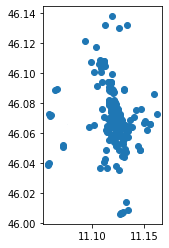

In [134]:
trento_pubs.plot()
plt.show()

Show all the paths from the train station to each location

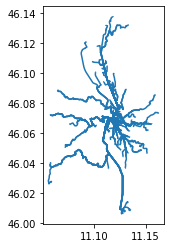

In [135]:
trento_pubs.set_geometry('linestring').plot()
plt.show()

calculate time for each path

In [136]:
def travel_time_from_train_station(inG, route):
  edge_times = ox.utils_graph.get_route_edge_attributes(inG, route, 'travel_time')
  return (sum(edge_times))

In [137]:
trento_pubs['travel_time_from_train_station'] = trento_pubs.travel_time_route_from_train_station.apply(lambda route: travel_time_from_train_station(network_onx,route))

and the length for each

In [138]:
def lenght_path_from_train_station(inG, route):
  edge_lengths = ox.utils_graph.get_route_edge_attributes(inG, route, 'length')
  return (sum(edge_lengths))

show the first 5 pubs by linear distance

In [139]:
trento_pubs['lenght_path_from_train_station'] = trento_pubs.travel_time_route_from_train_station.apply(lambda route: lenght_path_from_train_station(network_onx,route))

In [140]:
trento_pubs.sort_values(by=['distance_to_train_station']).head(10)[['name','distance_to_train_station']]

,name,distance_to_train_station
98,Bar Stazione Buffet Trento,31.089567
264,Flora,79.059449
265,Bar Caffetteria Dogana,173.832806
99,Bar Trento-Malé,186.993226
237,Liber Café,196.640913
241,Old Liberty Cafè,200.576391
172,Giornale & Caffè,218.444391
81,Bar Buonconsiglio,241.155413
151,Joyce,260.825053
127,Bar Magnani,290.978929


show the first 5 pubs by travel time distance (in seconds)

In [141]:
trento_pubs.sort_values(by=['travel_time_from_train_station']).head(10)[['name','travel_time_from_train_station']]

,name,travel_time_from_train_station
99,Bar Trento-Malé,15.7
264,Flora,20.8
98,Bar Stazione Buffet Trento,21.6
265,Bar Caffetteria Dogana,23.7
151,Joyce,27.2
81,Bar Buonconsiglio,30.3
226,Bar Biblioteca,31.2
60,Dersut Caffè,32.3
237,Liber Café,32.5
25,Osteria Trentina,33.4


In [142]:
trento_pubs.sort_values(by=['lenght_path_from_train_station']).head(10)[['name','lenght_path_from_train_station']]

,name,lenght_path_from_train_station
99,Bar Trento-Malé,209.036
98,Bar Stazione Buffet Trento,258.836
264,Flora,261.314
265,Bar Caffetteria Dogana,300.604
151,Joyce,356.175
81,Bar Buonconsiglio,392.252
226,Bar Biblioteca,399.974
60,Dersut Caffè,406.979
237,Liber Café,418.551
25,Osteria Trentina,423.619


## calculate the students (primary and secondary education) accessibility of the city of Trento

The autonomous province of Trento publishes the school's data on the vivoscuola.it website
Some data (schools and number of students) are available through Rest APIs (not documented).

The two main end points are:
- list of schools<br/>
https://aprilascuola.provincia.tn.it/sei//api/istituzioneScolastica/istituzioni/ricerca
- information of a single school providing the id<br/>
https://aprilascuola.provincia.tn.it/sei//api/ituzioneScolastica/istituzioni/CODE_OF_SCHOOL]


In [143]:
schools_url = "https://aprilascuola.provincia.tn.it/sei//api/istituzioneScolastica/istituzioni/ricerca"
search_school_url =  "https://aprilascuola.provincia.tn.it/sei//api/istituzioneScolastica/istituzioni/0CODE"
schools_trentino = pd.read_json(schools_url)
schools_in_trento = schools_trentino[schools_trentino.comune=='TRENTO']

In [144]:
schools_in_trento

,idobj,idPadre,codiceProvinciale,codiceMiur,denominazioneUfficiale,indirizzo,email,telefono,latitudeY,longitudeX,istituzionePadre,comune
4,13689,NaN,222059510,TNPS01000V,"LICEO SCIENTIFICO ""G. Galilei"" - TRENTO",Viale Bolognini 88,segr.liceogalilei@scuole.provincia.tn.it,0461/913479,46.063709,11.136057,"{'idobj': None, 'idPadre': None, 'codiceProvin...",TRENTO
5,13694,13689.0,222057111,TNPS01000V,LICEO SCIENTIFICO,Viale Bolognini 88,None,None,46.063709,11.136057,"{'idobj': 13689, 'idPadre': None, 'codiceProvi...",TRENTO
6,2237521,13689.0,222057130,TNPS01000V,LICEO SCIENTIFICO OPZIONE SCIENZE APPLICATE,Viale Bolognini 88,None,None,46.063709,11.136057,"{'idobj': 13689, 'idPadre': None, 'codiceProvi...",TRENTO
7,14190,NaN,222059511,TNPS02000D,"LICEO SCIENTIFICO ""L. Da Vinci"" - TRENTO",Via Madruzzo 24,segr.liceodavinci@scuole.provincia.tn.it,0461/984099,46.062715,11.120326,"{'idobj': None, 'idPadre': None, 'codiceProvin...",TRENTO
8,14191,14190.0,222057112,TNPS02000D,LICEO SCIENTIFICO,Via Madruzzo 24,None,None,46.062715,11.120326,"{'idobj': 14190, 'idPadre': None, 'codiceProvi...",TRENTO
...,...,...,...,...,...,...,...,...,...,...,...,...
638,2776697,1707708.0,222059696,TNCF004001,SETTORE INDUSTRIA E ARTIGIANATO,Piazza Di Fiera 4,None,None,NaN,NaN,"{'idobj': 1707708, 'idPadre': None, 'codicePro...",TRENTO
654,1707583,NaN,222059595,None,Istituto Formazione Professionale Servizi alla...,Viale Verona 141,ifp.trento@scuole.provincia.tn.it,0461/933147,46.052671,11.131164,"{'idobj': None, 'idPadre': None, 'codiceProvin...",TRENTO
655,3030050,1707583.0,222059670,None,SETTORE SERVIZI SERALE,Viale Verona 141,None,None,46.052671,11.131164,"{'idobj': 1707583, 'idPadre': None, 'codicePro...",TRENTO
656,2776551,1707583.0,222059693,TNFP268STA,SETTORE INDUSTRIA E ARTIGIANATO,Via Asiago 14,None,None,46.045498,11.137545,"{'idobj': 1707583, 'idPadre': None, 'codicePro...",TRENTO


In [145]:
schools_in_trento = schools_in_trento[~schools_in_trento.latitudeY.isnull()]

In [146]:
geo_schools_in_trento = gpd.GeoDataFrame(
    schools_in_trento,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(schools_in_trento.longitudeX, schools_in_trento.latitudeY))

In [147]:
geo_schools_in_trento.explore()

In [148]:
def getTotalStudents(idschool):
    idschool = str(idschool)
    if (len(idschool) > 4):
        search_school = search_school_url.replace("CODE",idschool)
    else:
        search_school = search_school_url.replace("0CODE",idschool)
    json_data = requests.get(search_school).json()
    totalstudents =  json_data['totaleStudenti']
    if (totalstudents == None):
        totalstudents = 0
    return totalstudents

In [149]:
%%time
geo_schools_in_trento['students'] = geo_schools_in_trento['codiceProvinciale'].apply(getTotalStudents)

CPU times: user 3.8 s, sys: 136 ms, total: 3.94 s
Wall time: 19.8 s


In [150]:
geo_schools_in_trento = geo_schools_in_trento[geo_schools_in_trento.students>0]

In [151]:
# Attach schools to Pandana graph
network_pandana.set_pois(category="school", maxdist=2000, maxitems=10, 
           x_col=geo_schools_in_trento.longitudeX, y_col=geo_schools_in_trento.latitudeY)

In [152]:
# Find the closest node-id for each school
node_ids = network_pandana.get_node_ids(geo_schools_in_trento.longitudeX, geo_schools_in_trento.latitudeY)

In [153]:
network_pandana.set(node_ids, variable=geo_schools_in_trento.students, name="students")

In [154]:
# Calculate the number of students (cumulative sum) from each node up to 500 meters
result = network_pandana.aggregate(500, type="sum", decay="linear", name="students")
result = result.to_frame(name="sum_students")

In [155]:
# Attach the information from nodes
result = nodes.merge(result, left_on="id", right_on=result.index)

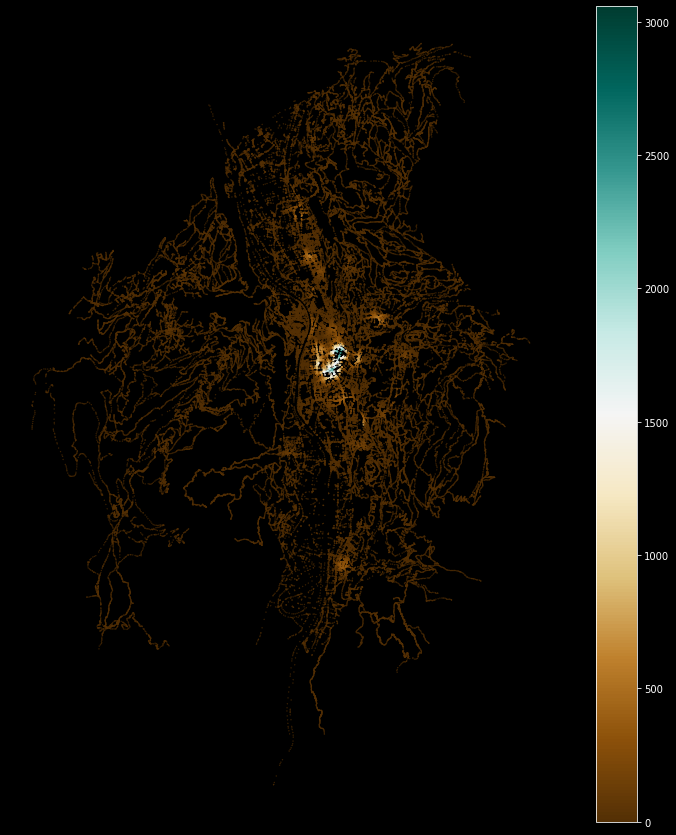

In [156]:
# Visualize the results
plt.style.use('dark_background')
ax = result.plot(column="sum_students",cmap='BrBG', markersize=0.1, legend=True, figsize=(15, 15))
plt.axis('off')
plt.show()

## identify the streets network orientation of this list of cities
## Trento - Italy, Udine - Italy,  Trieste - Italy, Bari - Italy, Cremona - Italy, Bergamo - Italy, Chengdu - China, Istanbul - Turkey 

The suggestion is to read the blog [Street Network Orientation](https://geoffboeing.com/2018/02/street-network-orientation/) post of [Geoff Boeing](https://geoffboeing.com/) (author of [OSMnx](https://geoffboeing.com/publications/osmnx-complex-street-networks/)) and adapt also che script present in the [examples section](https://github.com/gboeing/osmnx-examples) on the OSMnx github repository.

From the script you have simple to change the names of the cities ... and .. understand the code.

Here the result

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/street-orientations.png)



.. and here the result for all the main cities of Italy

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/italian_city_strees_orientation.jpg)


Vladimir Agafonkin created the web verson
 
![](https://github.com/napo/geospatial_course_unitn/blob/master/images/web_street_orientation.jpg?raw=true)

[https://mourner.github.io/road-orientation-map/#13.49/45.43646/12.33136](https://mourner.github.io/road-orientation-map/#13.49/45.43646/12.33136)

Here a simple map with the information of some cities in Trentino long the river Adige.

![](https://github.com/napo/geospatial_course_unitn/blob/master/images/trentino_orientamento_strade..jpg?raw=true)

[http://umap.openstreetmap.fr/en/map/orientamento-comuni-valle-delladige_234308#11/45.9588/11.1295](http://umap.openstreetmap.fr/en/map/orientamento-comuni-valle-delladige_234308#11/45.9588/11.1295)